In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [3]:
signal = ObjIter([Tree(f, report=False, altfile='test_{base}') for f in tqdm(module.signal_list)])
# signal = ObjIter([])

100%|██████████| 3/3 [00:14<00:00,  4.85s/it]


In [4]:
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='test_{base}')])


100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


'/eos/uscms/store/user/ekoenig/weaver/models/exp_feynnet_paper/feynnet_8b/20230503_ranger_lr0.0047_batch1024_mx_reweight_withbkg/'

In [7]:
model = eightb.models.feynnet_mx_reweight
(signal + bkg).apply( lambda t : eightb.load_feynnet_assignment(t, model.storage.replace('weaver/','weaver/analysis/')), report=True, parallel=True, thread_order=lambda t:len(t.obj) )

100%|██████████| 4/4 [00:49<00:00, 12.34s/it]


[None, None, None, None]

In [8]:
def higgs_m_chi2(t):
    return np.sqrt( ak.sum( (t.h_m-125)**2, axis=1 ) )
higgs_m_chi2.bins = (0,300,30)

100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


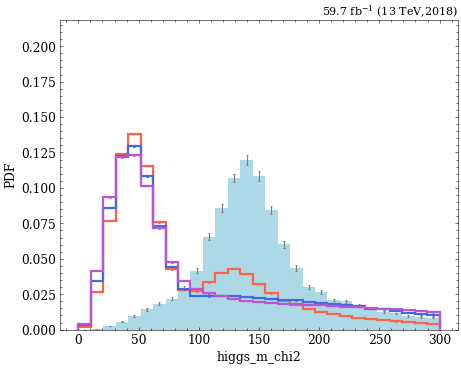

In [9]:
study.quick(
    signal+bkg,
    varlist=[higgs_m_chi2],
    efficiency=True,
)

In [10]:
varinfo.X_m =   dict(bins=(400,2000,30), )
varinfo.Y1_m =  dict(bins=(100,1000,30), )
varinfo.Y2_m =  dict(bins=(100,1000,30), )
varinfo.H1Y1_m =   dict(bins=(0,300,30), )
varinfo.H2Y1_m =   dict(bins=(0,300,30), )
varinfo.H1Y2_m =   dict(bins=(0,300,30), )
varinfo.H2Y2_m =   dict(bins=(0,300,30), )


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


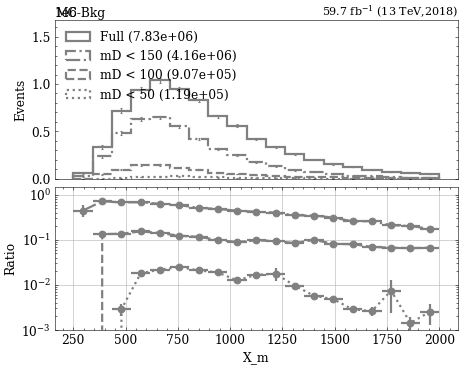

In [11]:
study.compare_masks(
    [],bkg,
    label=['Full','mD < 150','mD < 100','mD < 50'],
    masks =[None, lambda t : higgs_m_chi2(t) < 150, lambda t : higgs_m_chi2(t) < 100, lambda t : higgs_m_chi2(t) < 50],
    varlist=['X_m'],
    binlist=[(250,2000,20)],
    legend=True,

    ratio=True, r_inv=True, r_log=True, r_ylim=(1e-3,1.5),
    r_size="90%", 
    # efficiency=True,
)

100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


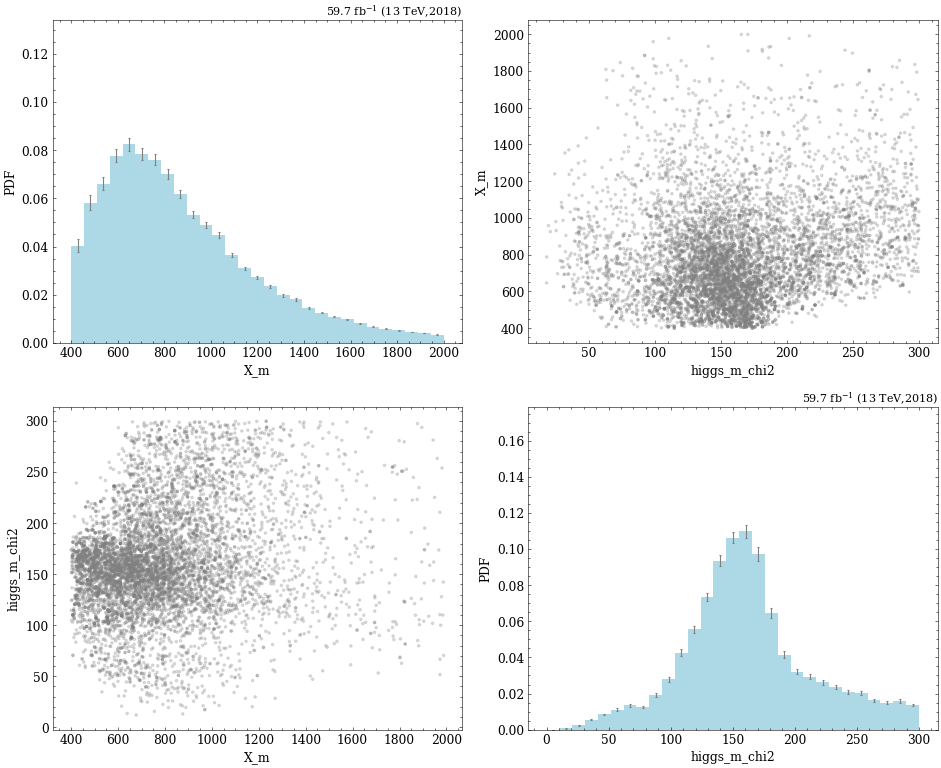

In [12]:
study.pairplot(
    bkg,
    varlist=['X_m',higgs_m_chi2],
    efficiency=True,
)

In [10]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))
partial_signal = signal.apply(EventFilter('partial_eightb', filter=lambda t : t.nfound_select< 8))

In [11]:
unique_mx = np.unique(eightb_signal.mx.npy)
unique_my = np.unique(eightb_signal.my.npy)

100%|██████████| 1/1 [00:07<00:00,  7.98s/it]

x_mean=16.000
x_std=9.522
x_min=0.000
x_max=32.000
y_mean=0.629
y_std=0.201
y_min=0.276
y_max=0.979
x_sum=528.000
y_sum=20.764
area=19.965
ndf=33.000


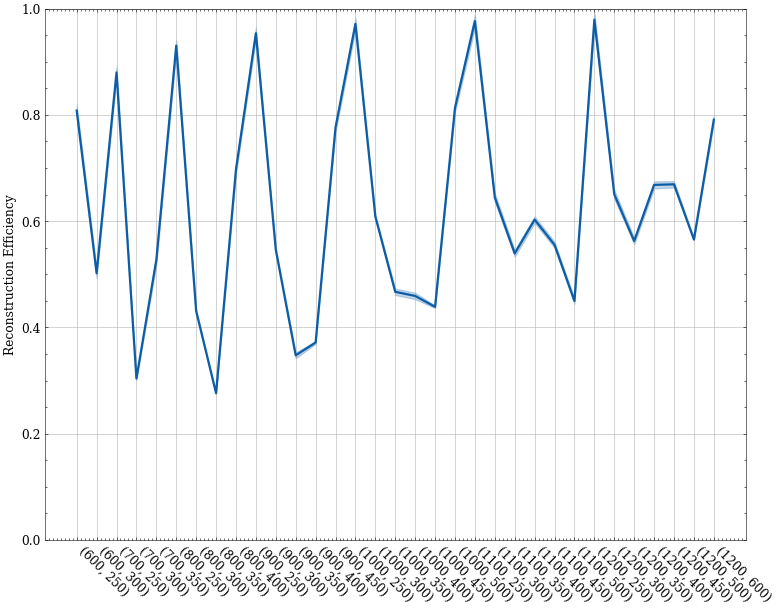

In [16]:
fig, ax = study.get_figax(size=(10,8))

study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
    g_ylim=(0,1),
    # g_g_label=f'MY={my}',
    # g_xlabel='MX',
    g_legend=True,
    figax=(fig,ax)
)

In [17]:
from utils.ak_tools import ak_argavg

In [18]:
eightb_signal_eff = eightb_signal.apply( lambda t : ak.mean(t.reco_id == 0) ).npy
extrema_signal = [eightb_signal_eff .argmin(), ak_argavg(eightb_signal_eff), eightb_signal_eff.argmax()]
extrema_signal = [7, 30, 26]


In [19]:
eightb_signal_eff[extrema_signal]

array([0.27627463, 0.6693526 , 0.97915266])

100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


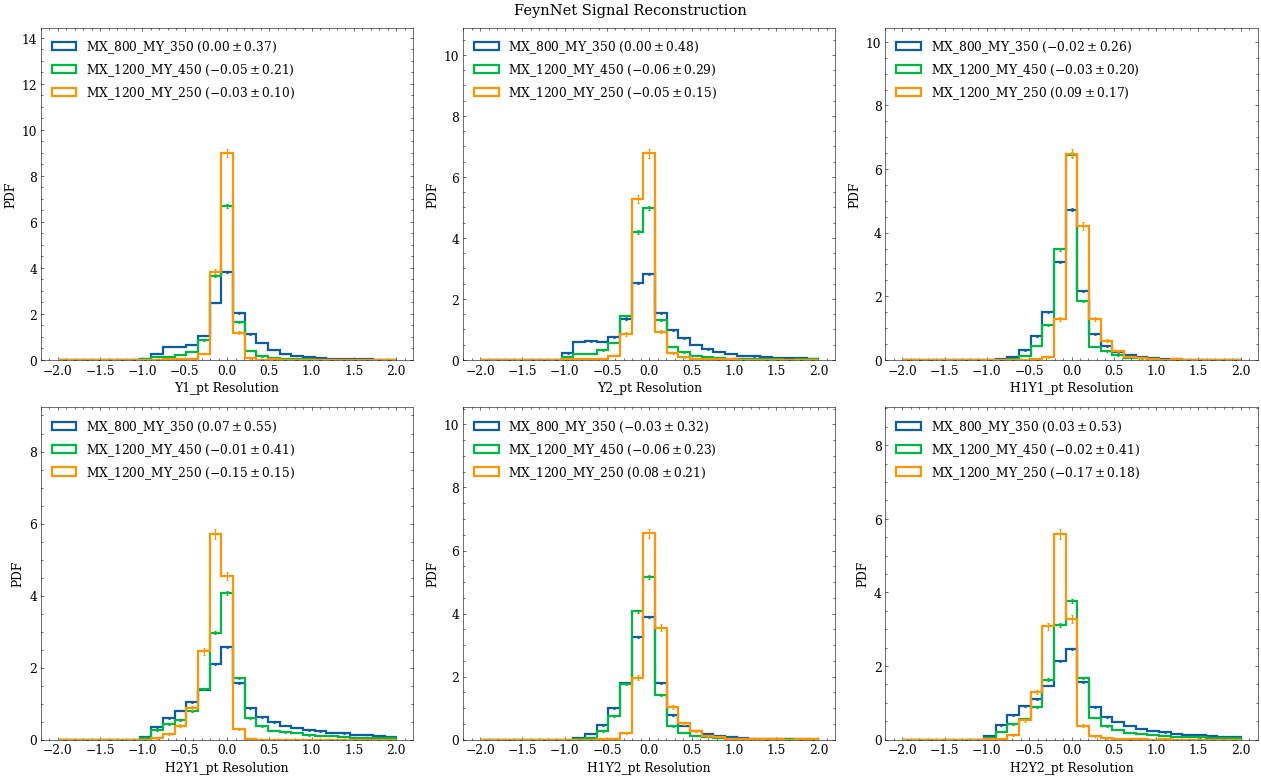

In [20]:
class gen_res(ObjTransform):
    def __init__(self, kin):
        self.kin = kin
    @property
    def xlabel(self): return f'{self.kin} Resolution'
    @property
    def bins(self): return (-2,2,30)
    def __call__(self, t):
        if self.kin is None: return
        return (t[self.kin]-t[f'gen_{self.kin}'])/t[f'gen_{self.kin}']

study.quick(
    eightb_signal[extrema_signal],
    legend=True,
    h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    varlist=[ gen_res(f'{res}_pt') for res in ['Y1','Y2','H1Y1','H2Y1','H1Y2','H2Y2']],
    suptitle='FeynNet Signal Reconstruction',
    h_restrict=True,
    lumi=None,
    density=True,
)

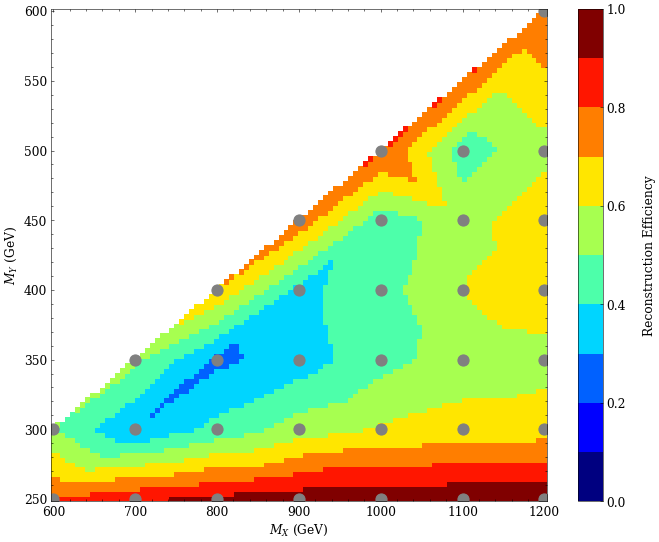

In [21]:
fig, ax = study.get_figax(size=(10,8))

study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    zlim=np.linspace(0,1,11),

    figax=(fig,ax)
)

# training_mx = eightb_signal[training_signal].mx
# training_my = eightb_signal[training_signal].my
# graph_array(training_mx, training_my, figax=(fig,ax), g_color='red', g_ls='none', xlim=None, ylim=None)



100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


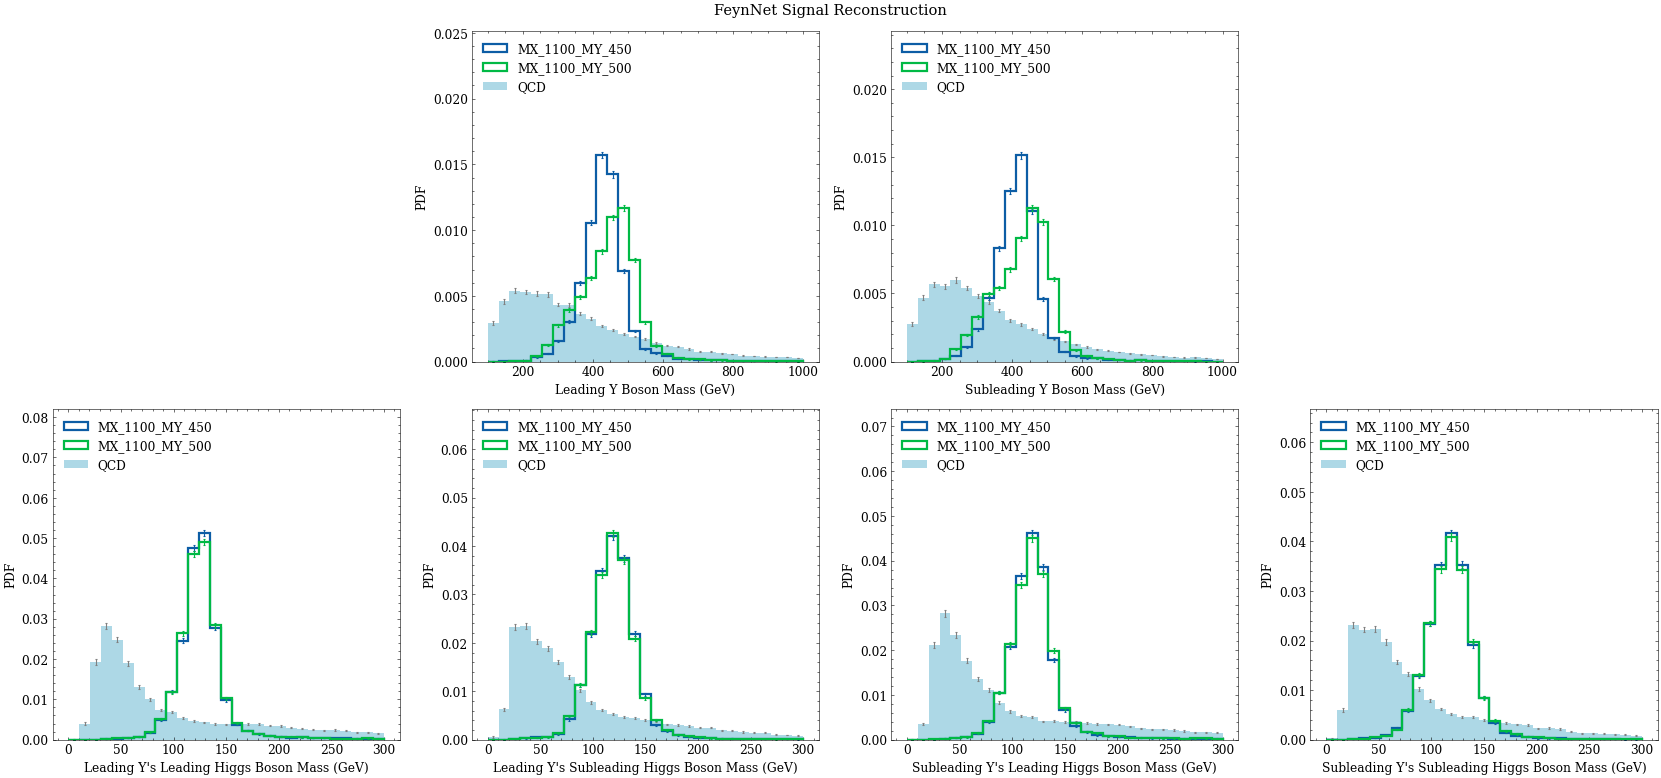

In [128]:
study.quick(
    eightb_signal[[24,25]]+bkg,
    
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

100%|██████████| 8/8 [00:01<00:00,  5.76it/s]


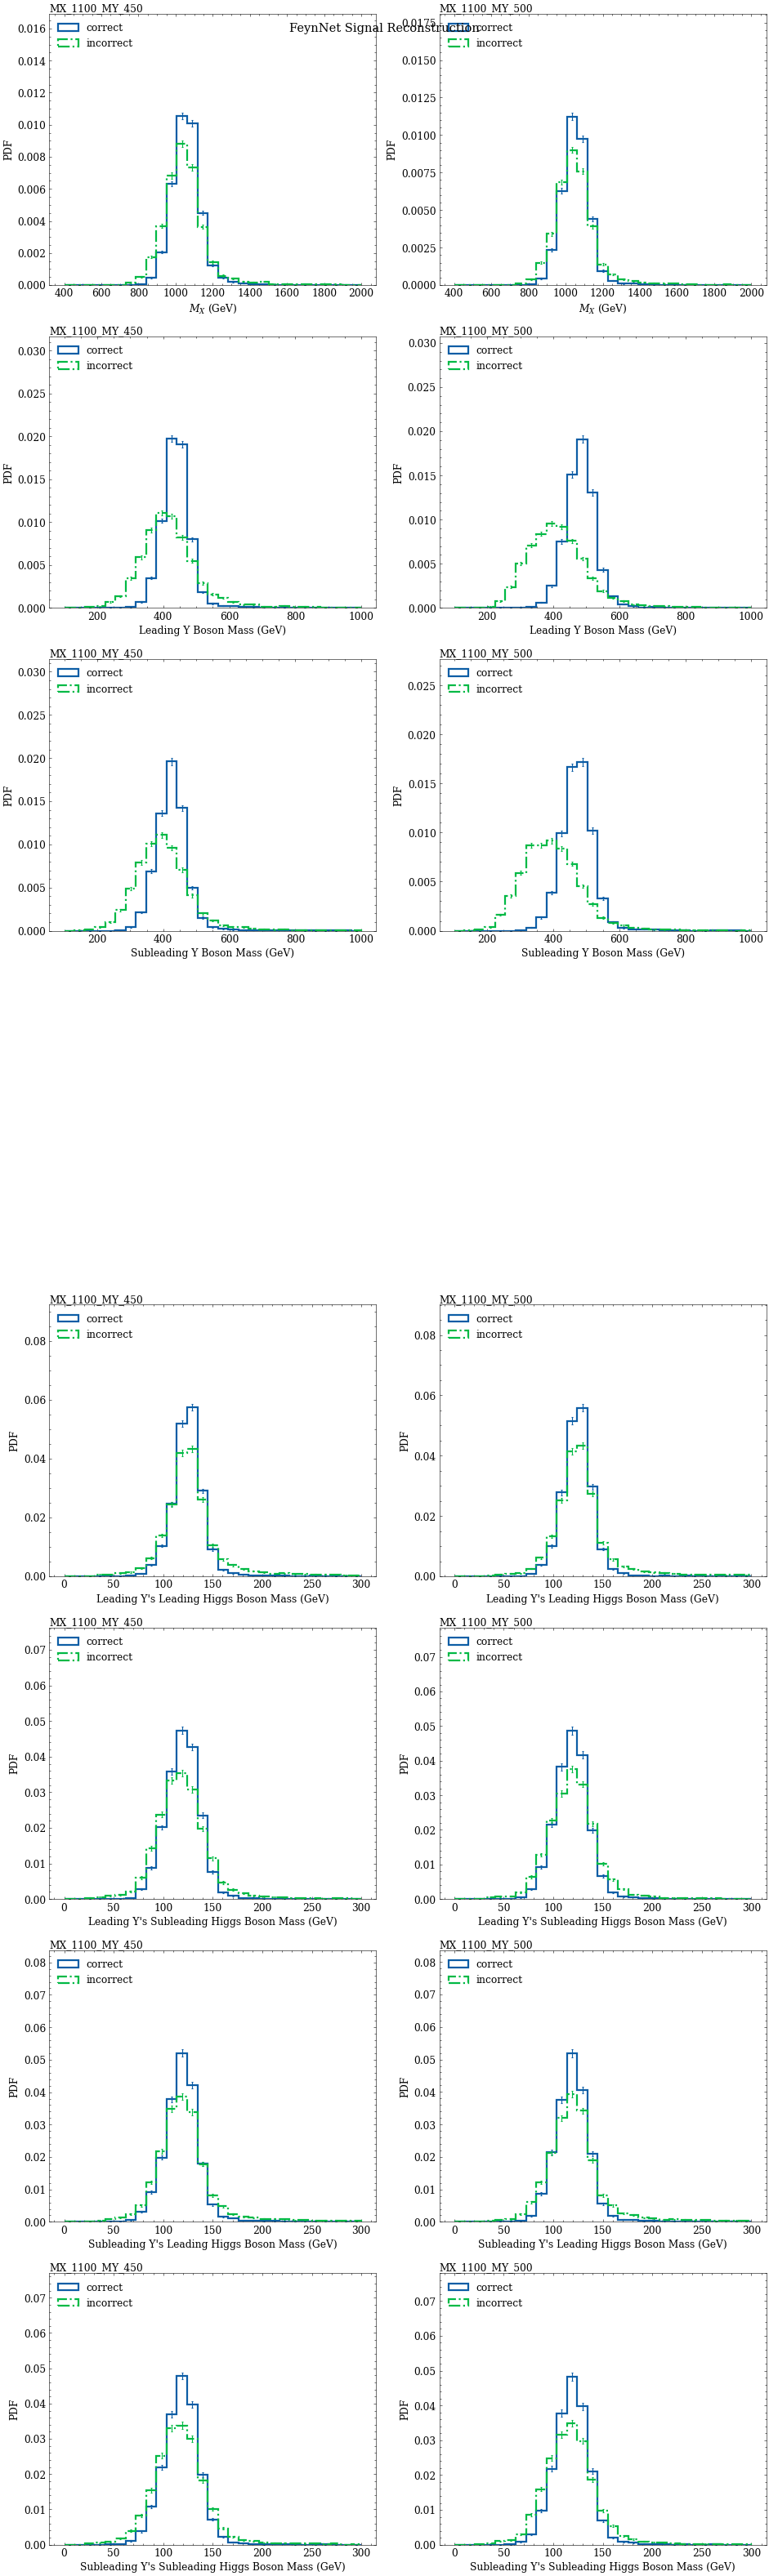

In [131]:
study.compare_masks(
    eightb_signal[[24,25]],
    masks=[lambda t : t.reco_id == 0, lambda t: t.reco_id==-1],
    label=['correct','incorrect'],
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

In [30]:
signal[0].mass == '(600, 250)'

True

In [48]:
selected = [ i for i,s in enumerate(signal) if s.mx == 1100  ]

In [73]:
def jet_ht(t):
    return ak.sum(t.jet_pt, axis=1)

def n_higgs(t):
    return ak.sum(t.higgs_signalId > -1, axis=1)

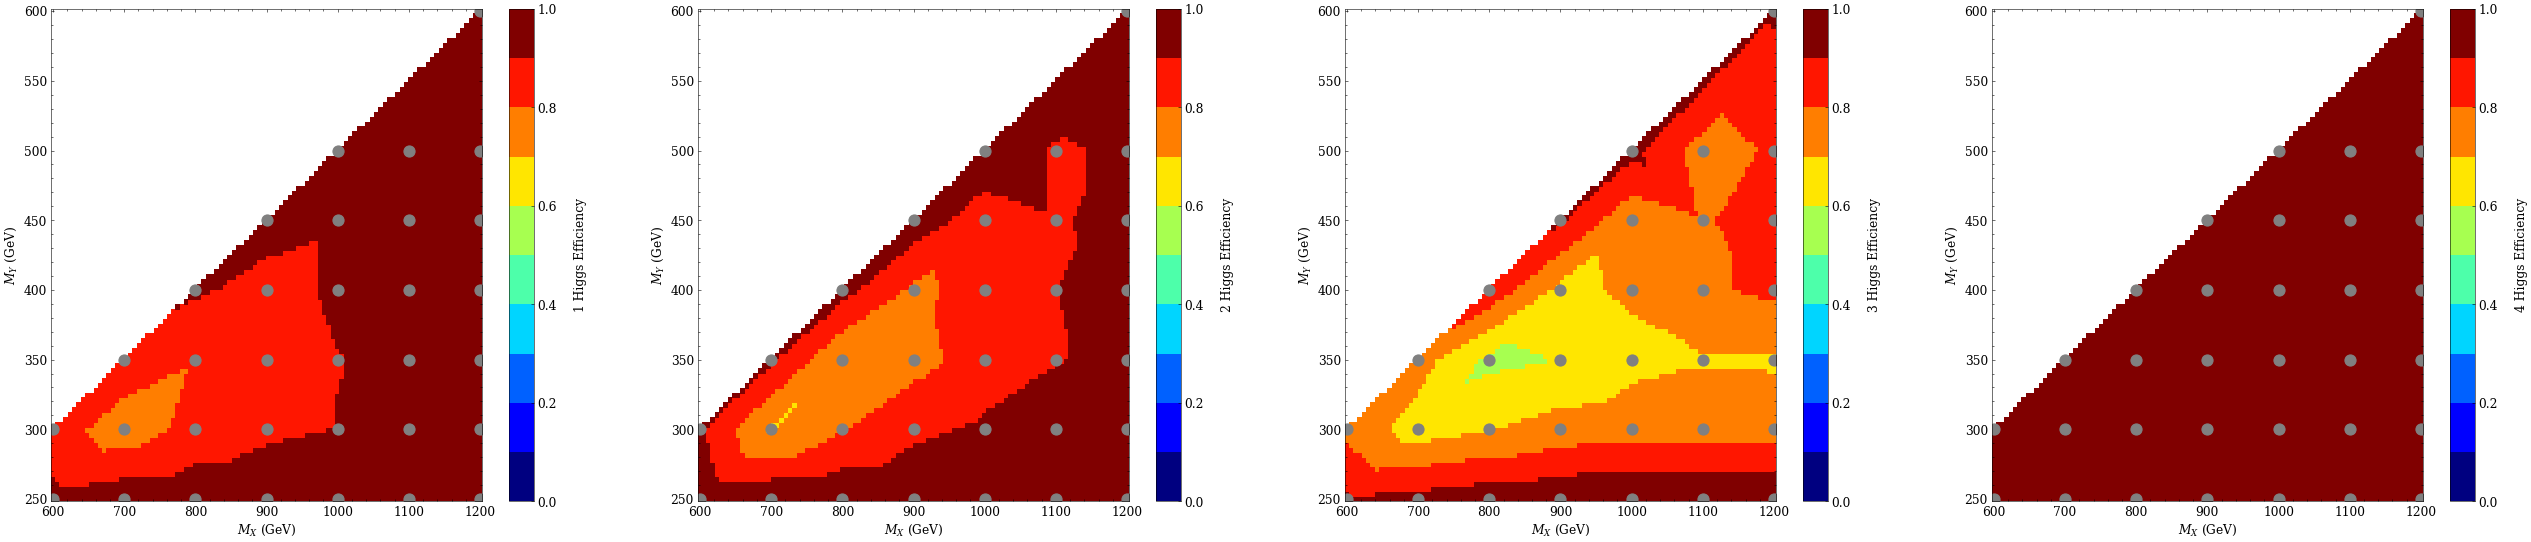

In [82]:
fig, axs = study.get_figax(nvar=4, size=(10,8), dim=-1)

for i,n in enumerate((1,2,3,4)):
    study.mxmy_phase(
        eightb_signal,
        label=signal.mass.list,
        zlabel=f'{n} Higgs Efficiency',
        efficiency=True,

        f_var=lambda t: ak.sum( n_higgs(t) >= n ) / ak.sum( n_higgs(t) >= (n-1) ),
        g_cmap='jet',

        xlabel='$M_X$ (GeV)',
        ylabel='$M_Y$ (GeV)',

        # xlim=(550,1250),
        # ylim=(200,650),
        zlim=np.linspace(0,1,11),

        figax=(fig,axs.flat[i])
    )

100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


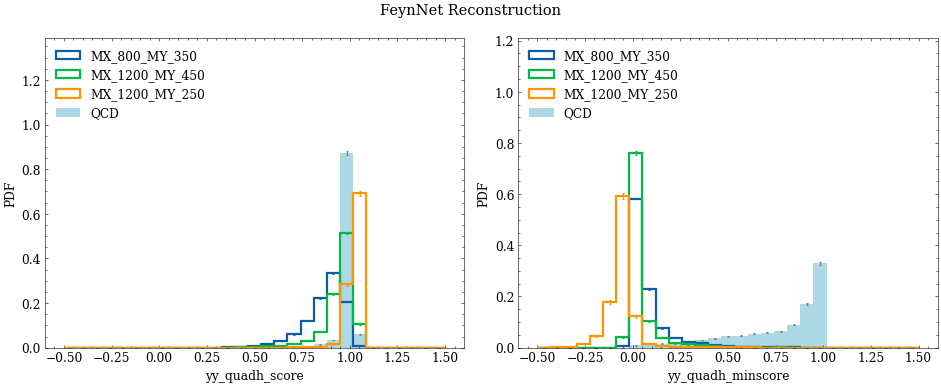

In [83]:
study.quick(
    eightb_signal[extrema_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['yy_quadh_score','yy_quadh_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


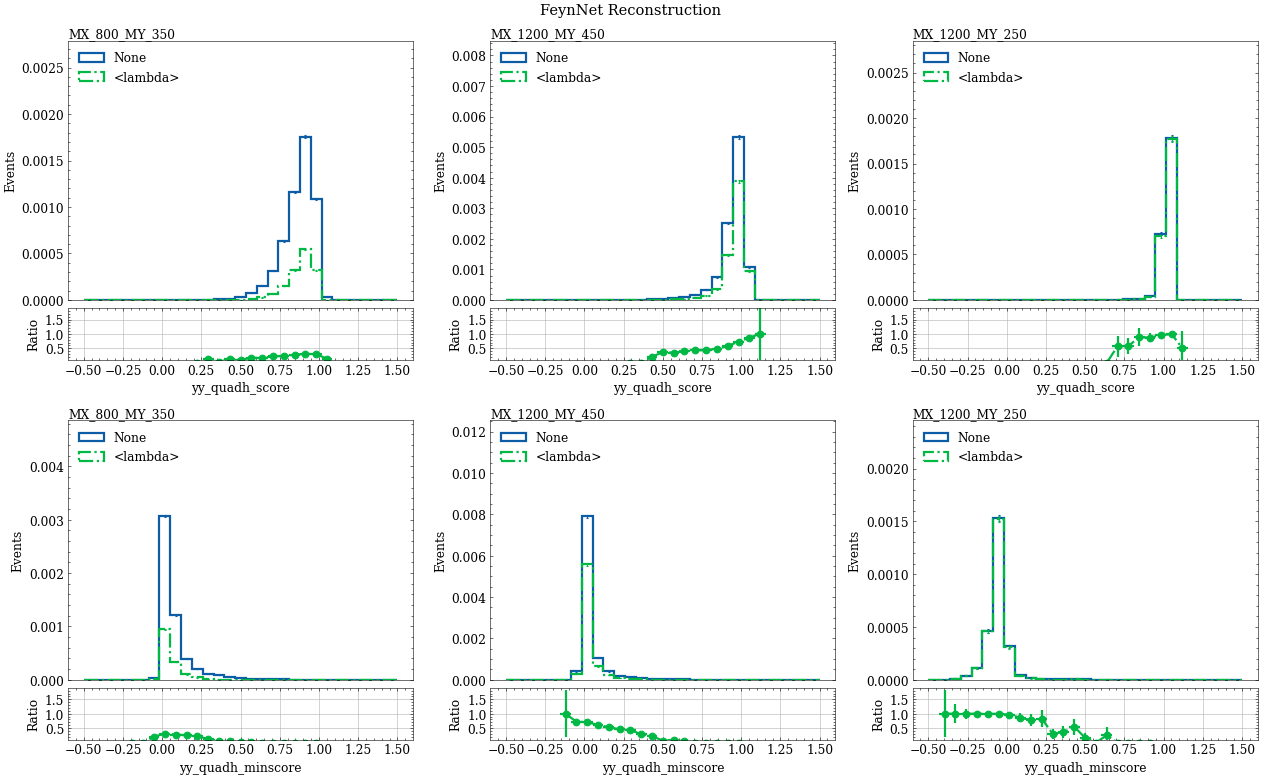

In [87]:
study.compare_masks(
    eightb_signal[extrema_signal],
    masks=[None, lambda t : t.reco_id == 0],
    legend=True,
    h_label_stat=None,
    varlist=['yy_quadh_score','yy_quadh_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    # efficiency=True,
    lumi=None,
    ratio=True, r_inv=True,
    # **study.auroc,
)

In [112]:

X = np.linspace(0.5,1,100)
Y = np.stack([ 
        eightb_signal.apply( lambda t : ak.mean(t.reco_id[(t.yy_quadh_score > cut)] == 0) ).npy
        for cut in tqdm(X)
     ])



100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


0.893939393939394

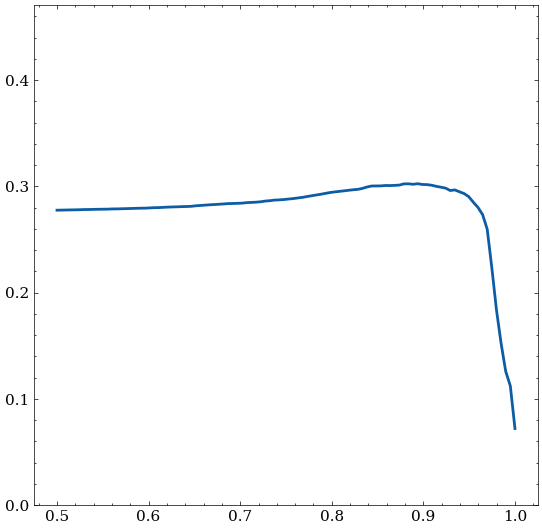

In [117]:
graph_array(X, Y.min(axis=1))
best_cut = X[Y.min(axis=1).argmax()]
best_cut

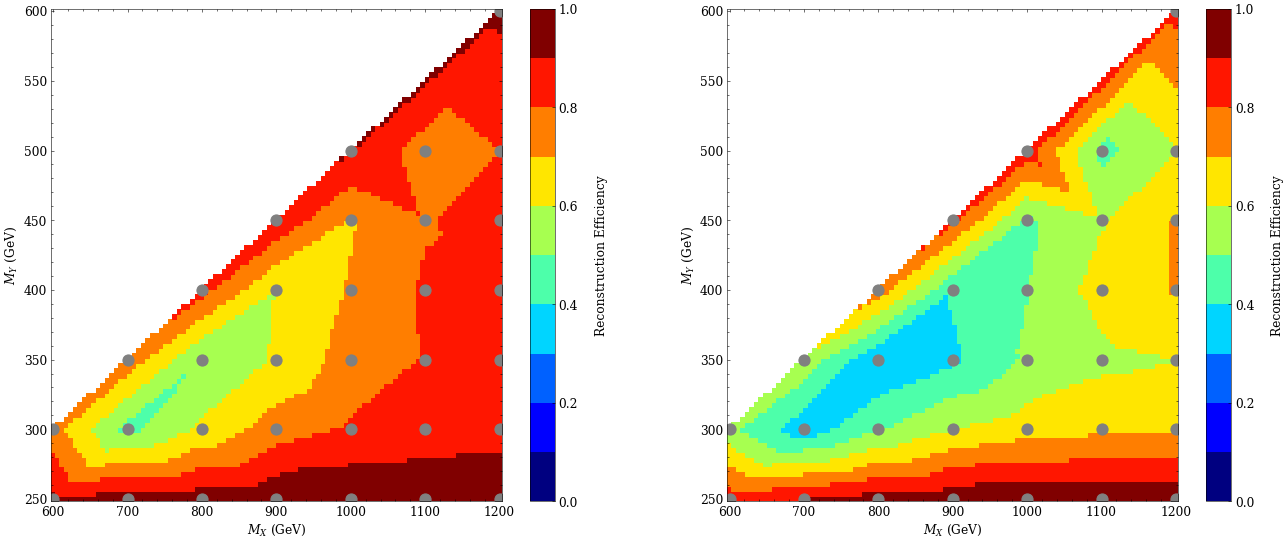

In [118]:
fig, axs = study.get_figax(nvar=2, size=(10,8), dim=-1)

selection = lambda t:t.yy_quadh_score>0.89

study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean( selection(t) ),
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    zlim=np.linspace(0,1,11),

    figax=(fig,axs.flat[0])
)

study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean( t.reco_id[selection(t)]==0 ),
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    zlim=np.linspace(0,1,11),

    figax=(fig,axs.flat[1])
)

# training_mx = eightb_signal[training_signal].mx
# training_my = eightb_signal[training_signal].my
# graph_array(training_mx, training_my, figax=(fig,ax), g_color='red', g_ls='none', xlim=None, ylim=None)



In [119]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='Leading Y Boson Mass (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='Subleading Y Boson Mass (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Subleading Higgs Boson Mass (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


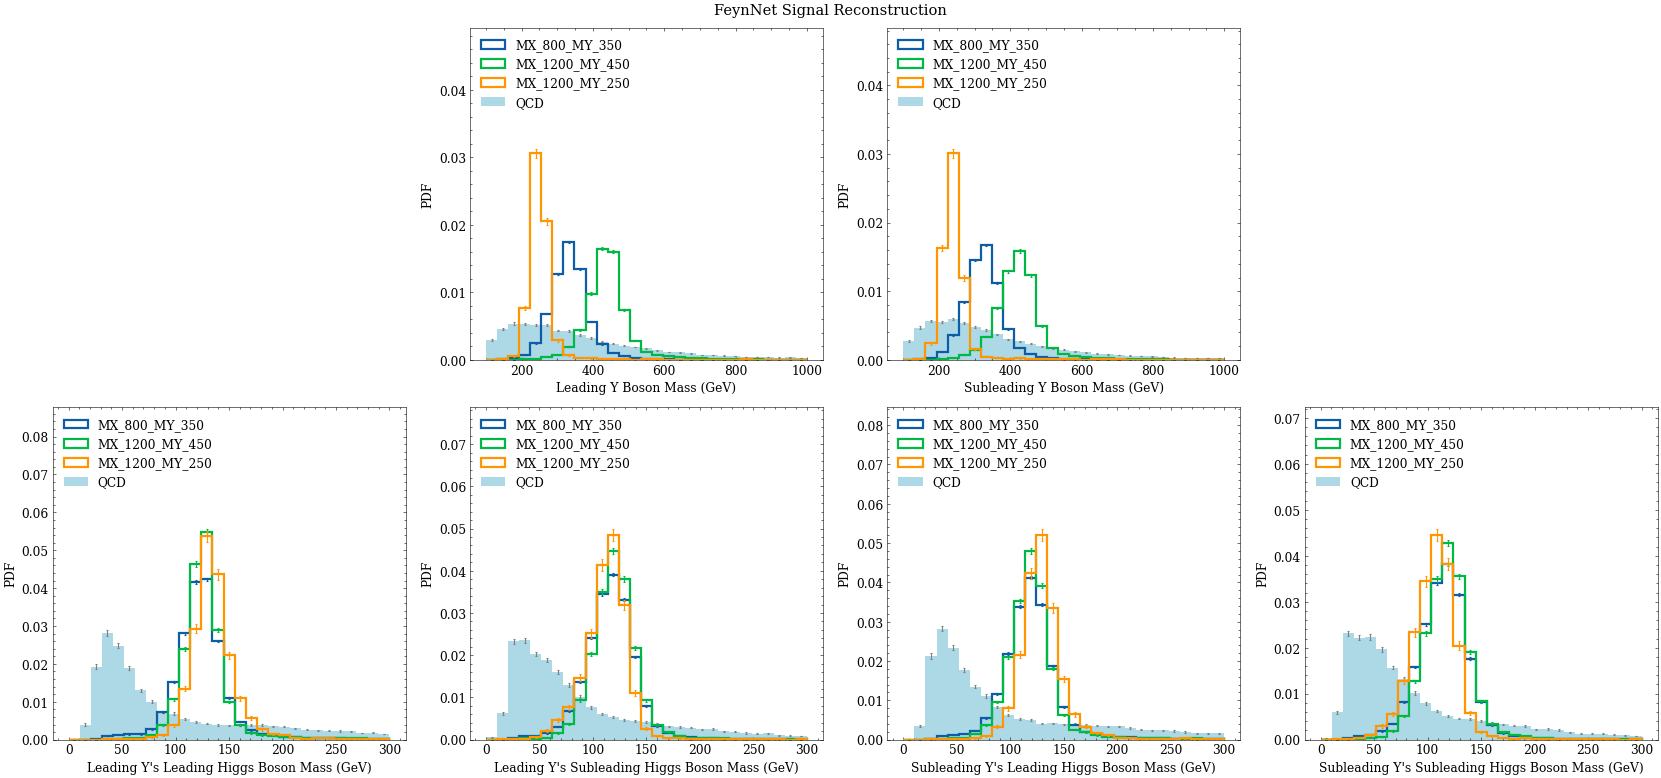

In [120]:
study.quick(
    eightb_signal[[7, 30, 26]]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


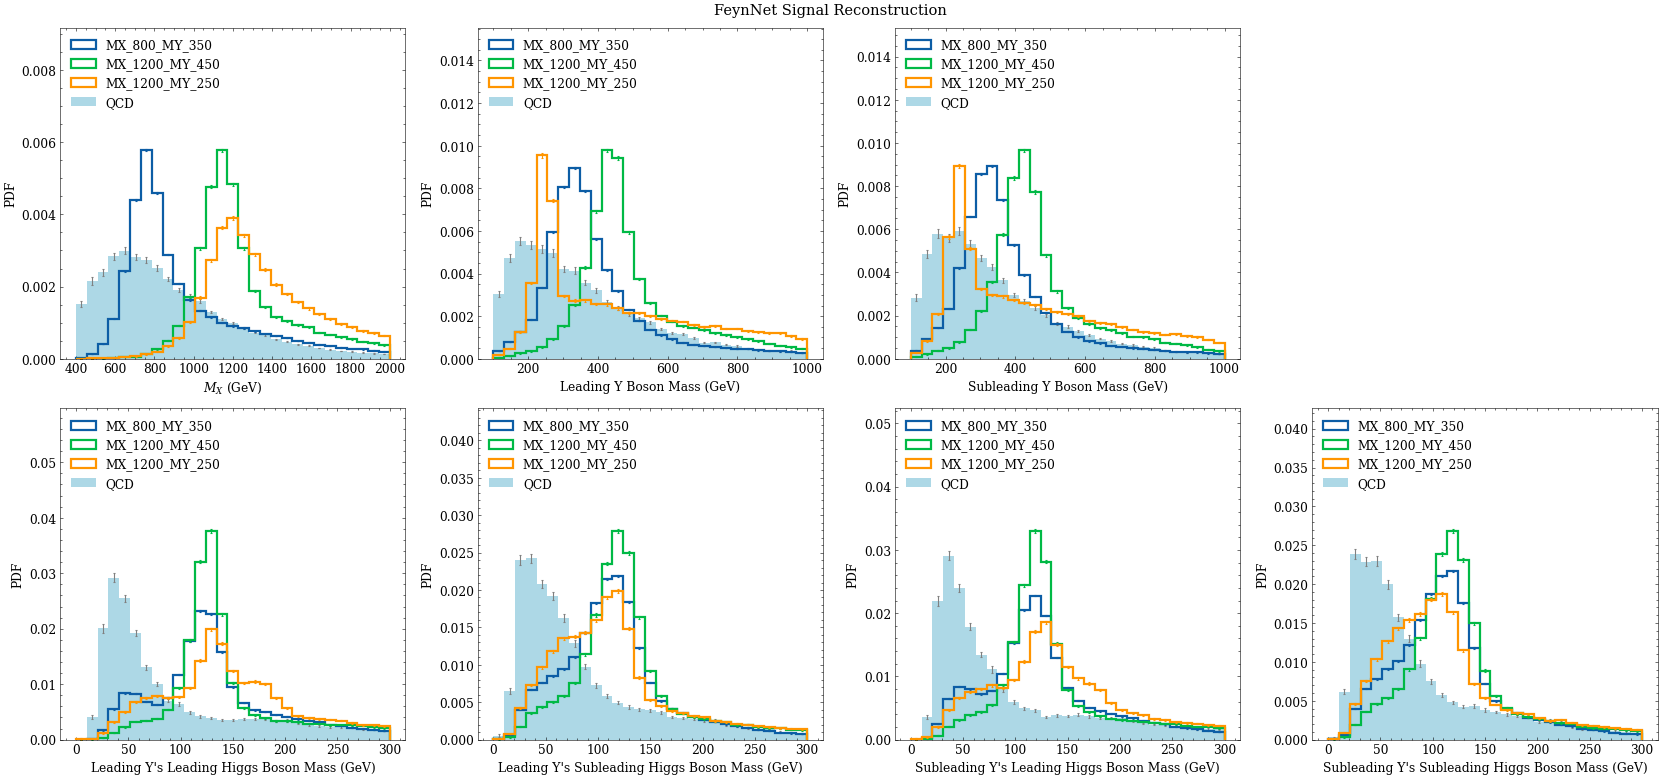

In [123]:
study.quick(
    signal[[7, 30, 26]]+bkg,
    masks=lambda t : t.yy_quadh_score > 0.89,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


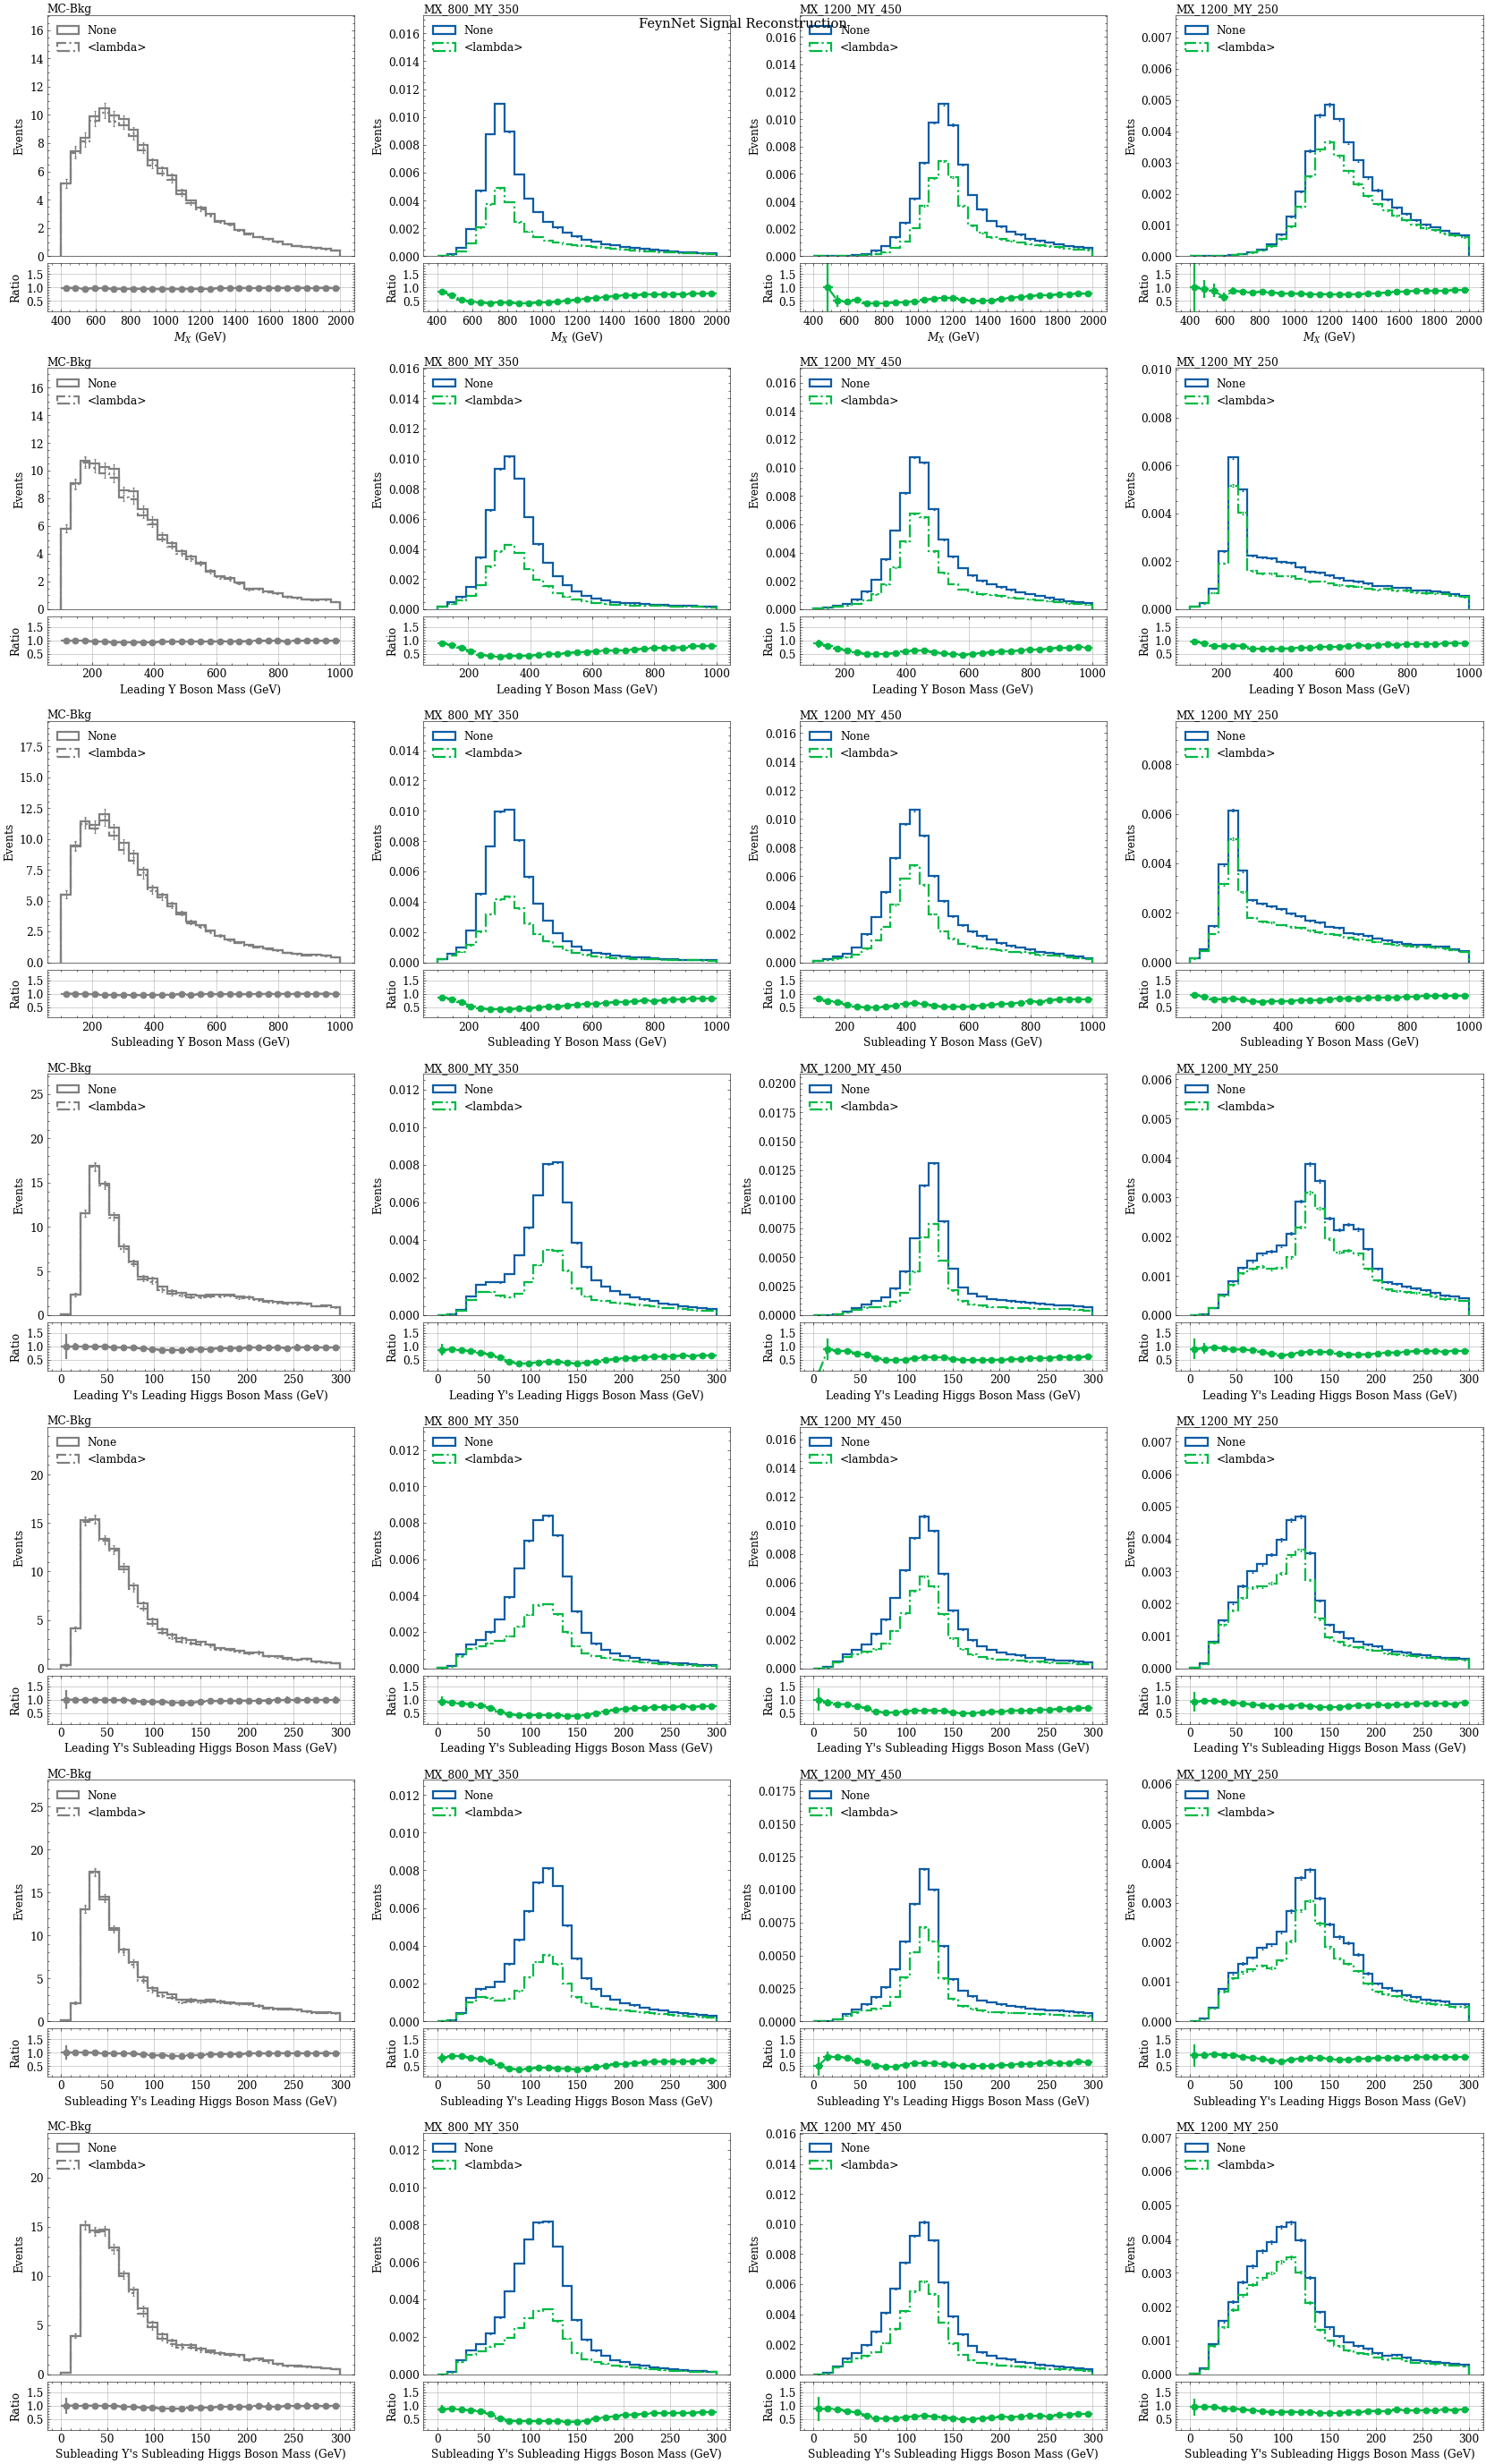

In [125]:
study.compare_masks(
    signal[[7, 30, 26]],bkg,
    masks=[None, lambda t : t.yy_quadh_score > 0.89],
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m','H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    ratio=True,r_inv=True,
)

100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


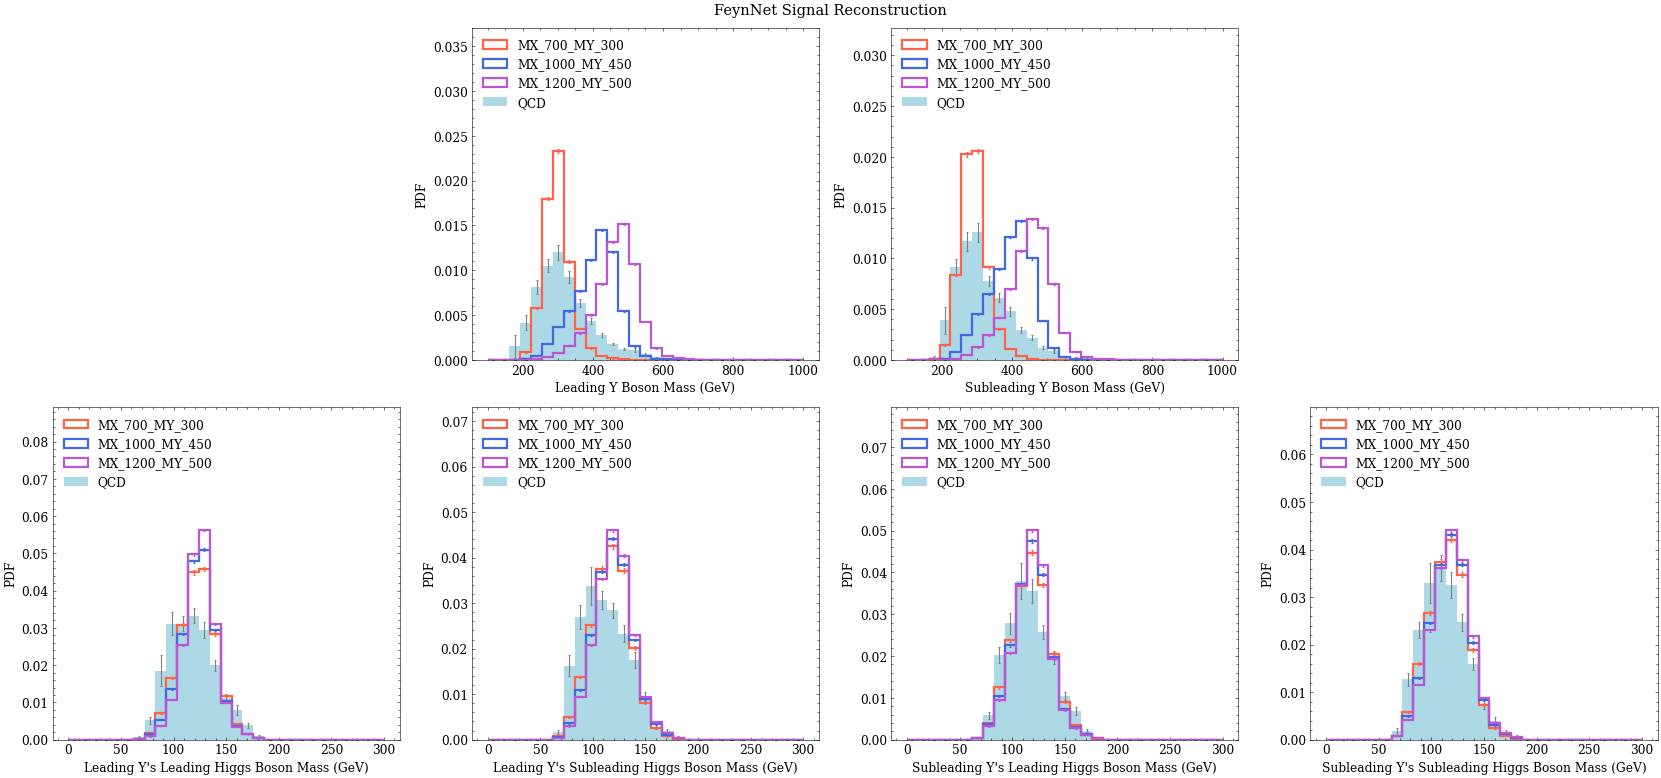

In [16]:
study.quick(
    eightb_signal[use_signal]+bkg,
    masks=lambda t : np.sqrt( np.sum( (t.higgs_m-125)**2, axis=1 ) ) < 125/2,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

In [ ]:
eightb_signal.apply(lambda t : t.extend(norm_scale=1/(len(t) * t.scale)))
bkg.apply(lambda t : t.extend(norm_scale=ak.ones_like(t.scale)))


[None]

100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


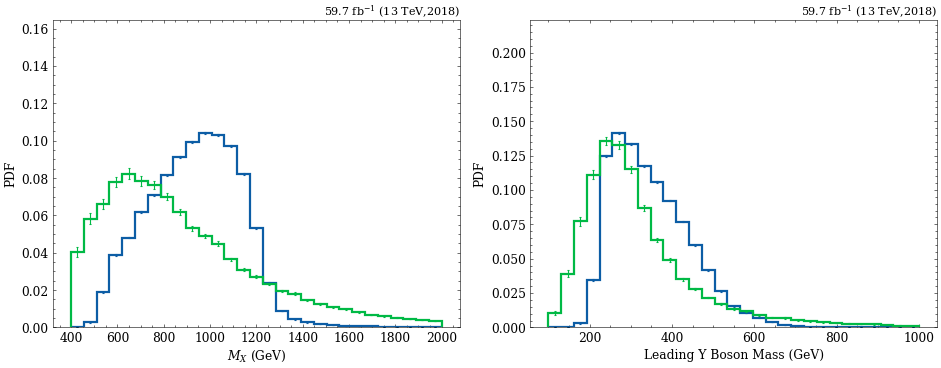

In [ ]:
study.quick_region(
    eightb_signal,bkg,
    scale=lambda t : t.norm_scale,
    varlist=['X_m','Y1_m'],
    efficiency=True,

)